>>> 1: підготовка середовищах
>>> 2: ознайомлення з даними
   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton 

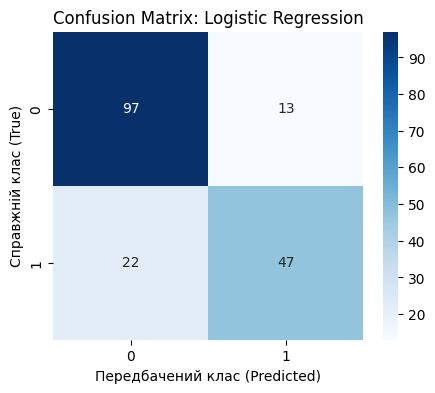


--- Decision Tree ---
Accuracy (Точність):  0.7765
Precision (Влучність): 0.7101
Recall (Повнота):     0.7101
F1-score (Баланс):    0.7101


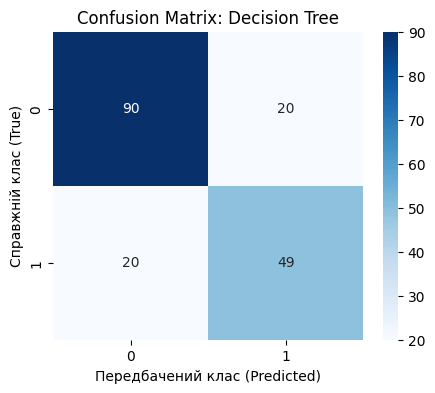


--- Random Forest ---
Accuracy (Точність):  0.8101
Precision (Влучність): 0.7692
Recall (Повнота):     0.7246
F1-score (Баланс):    0.7463


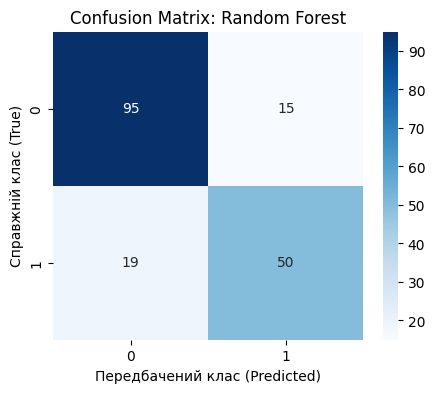


>>> 7: оптимізація моделі
Logistic Regression CV: 0.7964247020585048
Decision Tree CV:       0.7725499852260416

--- Пошук найкращих параметрів для Random Forest ---
Найкращі параметри: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

--- Optimized Random Forest ---
Accuracy (Точність):  0.8045
Precision (Влучність): 0.7833
Recall (Повнота):     0.6812
F1-score (Баланс):    0.7287


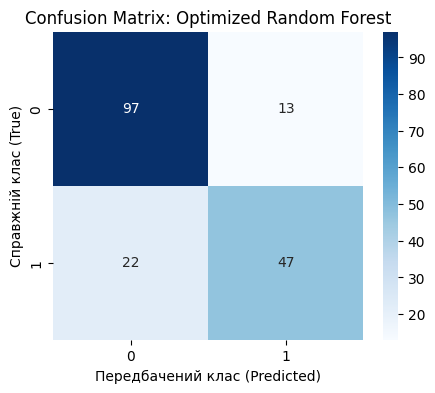


>>> 8: Порівняння моделей


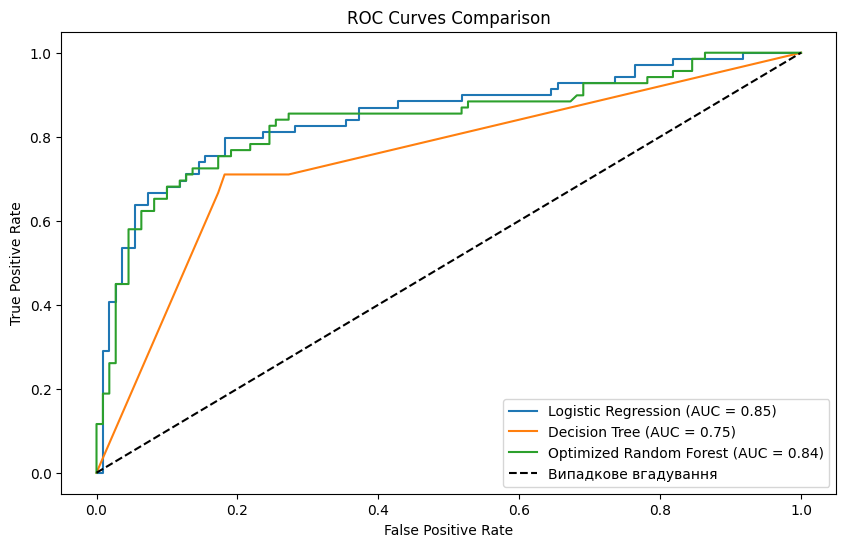


>>> 9: Завдання з творчим підходом


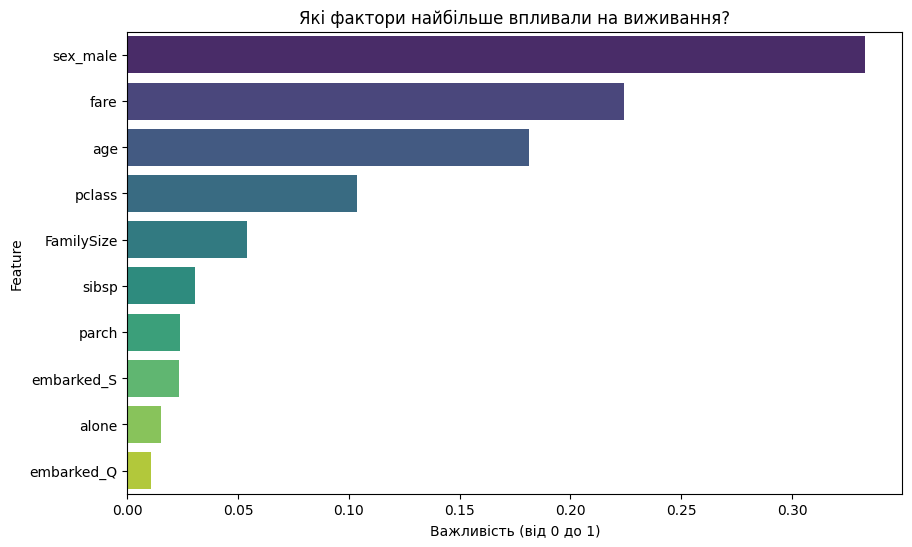

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# 1. Підготовка середовища
print(">>> 1: підготовка середовищах")
df = sns.load_dataset('titanic')

# 2. Ознайомлення з даними
print(">>> 2: ознайомлення з даними")
print(df.head(10))

print("\n--- Статистика (Describe) ---")
print(df.describe())

print("\n--- Пропущені значення до обробки ---")
print(df.isnull().sum())

# 3. Попередня обробка даних
print("\n>>> 3: попередня обробка даних")

# Age: Заповнюємо середнім
df['age'] = df['age'].fillna(df['age'].mean())

# Embarked: Заповнюємо модою (найчастішим значенням)
most_common_embarked = df['embarked'].mode()[0]
df['embarked'] = df['embarked'].fillna(most_common_embarked)

# Видалення зайвих колонок
# alive, who, adult_male, class - це дублікати існуючих даних
# deck - має критично багато пропусків
cols_to_drop = ['deck', 'embark_town', 'alive', 'who', 'adult_male', 'class']
df = df.drop(columns=cols_to_drop, errors='ignore')

# Кодування категоріальних змінних (One-Hot Encoding)
# drop_first=True важливий для лінійних моделей (уникаємо мультиколінеарності)
df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True)

# Створення нових ознак (Feature Engineering)
# Розмір сім'ї = брати/сестри + батьки/діти
df['FamilySize'] = df['sibsp'] + df['parch']

print("\n--- Дані після обробки (готові до навчання) ---")
print(df.head(10))

# 4. Поділ даних на тренувальну та тестову вибірки
print("\n>>> 4: поділ даних на тренувальну та тестову вибірки")
X = df.drop('survived', axis=1)
y = df['survived']

# Stratify=y гарантує, що відсоток виживших у Train і Test буде однаковий
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5 & 6. Побудова моделей та оцінка результатів
print("\n>>> 5-6: побудова моделей та оцінка результатів")

def evaluate_model(model, name):
    print(f"\n--- {name} ---")
    
    # Тренування
    model.fit(X_train, y_train)
    
    # Передбачення
    y_pred = model.predict(X_test)
    
    # Метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy (Точність):  {acc:.4f}")
    print(f"Precision (Влучність): {prec:.4f}")
    print(f"Recall (Повнота):     {rec:.4f}")
    print(f"F1-score (Баланс):    {f1:.4f}")
    
    # Візуалізація матриці невідповідностей
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Справжній клас (True)')
    plt.xlabel('Передбачений клас (Predicted)')
    plt.show()
    
    return model

# Ініціалізація
log_reg = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Запуск оцінки
log_reg = evaluate_model(log_reg, "Logistic Regression")
dt = evaluate_model(dt, "Decision Tree")
rf = evaluate_model(rf, "Random Forest")

# 7. Оптимізація моделі
print("\n>>> 7: оптимізація моделі")

# 7.1. Крос-валідація
print("Logistic Regression CV:", cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy').mean())
print("Decision Tree CV:      ", cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy').mean())

# 7.2. GridSearchCV для Random Forest
print("\n--- Пошук найкращих параметрів для Random Forest ---")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Найкращі параметри:", grid_search.best_params_)

# Оцінка вже оптимізованої моделі
evaluate_model(best_rf, "Optimized Random Forest")

# 8. Порівняння моделей
print("\n>>> 8: Порівняння моделей")
plt.figure(figsize=(10, 6))

# Порівнюємо базові моделі та оптимізований ліс
models_list = [
    (log_reg, "Logistic Regression"),
    (dt, "Decision Tree"),
    (best_rf, "Optimized Random Forest") # Використовуємо найкращу версію лісу
]

for model, name in models_list:
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Випадкове вгадування')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# 9. Завдання з творчим підходом
print("\n>>> 9: Завдання з творчим підходом")
importances = best_rf.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, hue='Feature', palette='viridis', legend=False)
plt.title('Які фактори найбільше впливали на виживання?')
plt.xlabel('Важливість (від 0 до 1)')
plt.show()